In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [65]:
# helper functions 

def sigmoid(Z):
  A = 1/(1 + np.exp(-Z))
  cache = Z;
  return A, cache

def relu(Z):
  A =  np.maximum(0, Z)
  assert(A.shape == Z.shape)

  cache = Z
  return A, cache

def sigmoid_backward(dA, cache):
  Z = cache
  s = 1/(1 + np.exp(-Z))
  
  dZ = dA * s * (1-s)

  assert(dZ.shape == Z.shape)

  return dZ

def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  
  dZ[Z <= 0] = 0
  
  assert(dZ.shape == Z.shape)

  return dZ


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


# initialing paramters

def initialize_parameters(n_x, n_h, n_y):
  np.random.seed(1)

  W1 = np.random.randn(n_h, n_x)*0.01
  b1 = np.zeros((n_h, 1))
  W2 = np.random.randn(n_y, n_h)*0.01
  b2 = np.zeros((n_y, 1))

  parameters = {
      "W1": W1,
      "W2": W2,
      "b1": b1,
      "b2": b2
  }
  return parameters

def initialize_parameters_deep(layer_dims):
  np.random.seed(3)

  parameters = {}

  for i in range(1, len(layer_dims)):
    parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
    parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))

  return parameters


# forward propagation

def linear_forward(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  
  return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
  Z, linear_cache = linear_forward(A_prev, W, b)
  if activation == 'sigmoid':
    A, activation_cache = sigmoid(Z)
  
  elif activation == 'relu':
    A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache)
  return A, cache;


def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters) // 2

  for i in range(1, L):
    A_prev = A
    A, cache = linear_activation_forward(A_prev, parameters['W'+str(i)], parameters['b'+str(i)], 'relu')
    caches.append(cache)
  
  A_prev = A
  AL, cache = linear_activation_forward(A_prev, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid')
  caches.append(cache)

  assert(AL.shape == (1,X.shape[1]))

  return AL, caches

def compute_cost(AL, Y):
  m = Y.shape[1]
  cost = -np.sum( np.dot(AL, np.log(AL).T) + np.dot(1-AL, np.log(1-AL).T) ) / m
  cost = np.squeeze(cost)
  
  return cost


# backward propagation

def linear_backward(dZ, cache):
  A_prev, W, b = cache;
  m = A_prev.shape[1]

  dW = np.dot(dZ, A_prev.T) / m
  db = np.sum(dZ, axis = 1, keepdims = True) / m
  dA_prev = np.dot(W.T, dZ)

  return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache

  if activation == 'sigmoid':
    dZ = sigmoid_backward(dA, activation_cache)
   
  elif activation == 'relu':
    dZ = relu_backward(dA, activation_cache)

  dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
  grads = {}
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)
  L = len(caches)

  dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
  current_cache = caches[L-1]
  dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')

  grads["dA" + str(L-1)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp

  for i in reversed(range(len(caches) - 1)):
    current_cache = caches[i]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads['dA'+str(i+1)], current_cache, 'relu')

    grads["dA" + str(i)] = dA_prev_temp
    grads["dW" + str(i+1)] = dW_temp
    grads["db" + str(i+1)] = db_temp
  
  return grads


def update_parameters(params, grads, learning_rate):
  new_params = params.copy()
  
  for i in range(len(params)//2):
    new_params['W' + str(i+1)] -=  learning_rate * grads["dW" + str(i+1)]
    new_params['b' + str(i+1)] -=  learning_rate * grads["db" + str(i+1)]

  return new_params


def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [3]:
import time
import scipy
from PIL import Image
from scipy import ndimage


Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


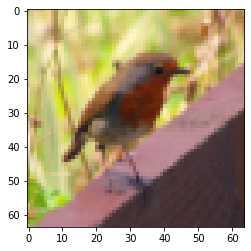

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
plt.imshow(train_x_orig[10])

m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

In [5]:
# reshaping

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Cost after iteration 0: 0.6931425328950368
Cost after iteration 100: 0.6502302838955509
Cost after iteration 200: 0.6470433845799937
Cost after iteration 300: 0.6351902747161783
Cost after iteration 400: 0.6065049881761729
Cost after iteration 500: 0.5821487816657293
Cost after iteration 600: 0.5749114879825317
Cost after iteration 700: 0.5633491221172777
Cost after iteration 800: 0.5330974307266038
Cost after iteration 900: 0.4947785830014003
Cost after iteration 1000: 0.4551013116994881
Cost after iteration 1100: 0.41372317802965497
Cost after iteration 1200: 0.3838981379099452
Cost after iteration 1300: 0.37684495222743647
Cost after iteration 1400: 0.31552595795686006
Cost after iteration 1500: 0.31894070724732815
Cost after iteration 1600: 0.2440025199956712
Cost after iteration 1700: 0.22539705684384614
Cost after iteration 1800: 0.20333031785658673
Cost after iteration 1900: 0.1871739026479238
Cost after iteration 2000: 0.1722209148695786
Cost after iteration 2100: 0.15975429133

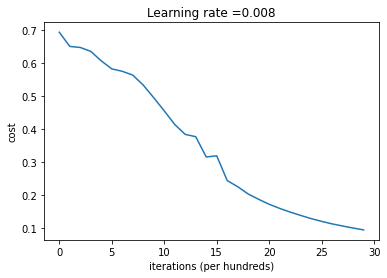

In [46]:
n_x = 12288
n_h = 7
n_y = 1
layer_dims = (n_x, n_h, n_y)

# two layer model

def two_layer_model(X, Y, layer_dims, learning_rate = 0.008, num_iterations = 3000, print_cost = True):
  np.random.seed(1)
  grads = {}
  costs = []
  m = X.shape[1]
  (n_x, n_h, n_y) = layer_dims
  parameters = initialize_parameters(n_x, n_h, n_y)

  for i in range(0, num_iterations):

    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    # forward propagation
    A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
    A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')

    # compute cost
    cost = compute_cost(A2, Y)
    
    # backward propagation
    dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
    dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
    dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')

    grads['dW1'] = dW1
    grads['dW2'] = dW2
    grads['db1'] = db1
    grads['db2'] = db2

    parameters = update_parameters(parameters, grads, learning_rate)

    if print_cost and i % 100 == 0:
      print('Cost after iteration {}: {}'.format(i, cost))
      costs.append(cost)

  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return parameters


parameters = two_layer_model(train_x, train_y, layer_dims = (n_x, n_h, n_y))

In [48]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.72


Cost after iteration 0: 0.693142
Cost after iteration 100: 0.651327
Cost after iteration 200: 0.647503
Cost after iteration 300: 0.642523
Cost after iteration 400: 0.622553
Cost after iteration 500: 0.595904
Cost after iteration 600: 0.584709
Cost after iteration 700: 0.555766
Cost after iteration 800: 0.532124
Cost after iteration 900: 0.506836
Cost after iteration 1000: 0.478290
Cost after iteration 1100: 0.446528
Cost after iteration 1200: 0.424264
Cost after iteration 1300: 0.397175
Cost after iteration 1400: 0.330410
Cost after iteration 1500: 0.311564
Cost after iteration 1600: 0.297717
Cost after iteration 1700: 0.360756
Cost after iteration 1800: 0.238626
Cost after iteration 1900: 0.218983
Cost after iteration 2000: 0.200554
Cost after iteration 2100: 0.184283
Cost after iteration 2200: 0.169754
Cost after iteration 2300: 0.156953
Cost after iteration 2400: 0.145652
Cost after iteration 2500: 0.135640
Cost after iteration 2600: 0.126742
Cost after iteration 2700: 0.118948
Cost

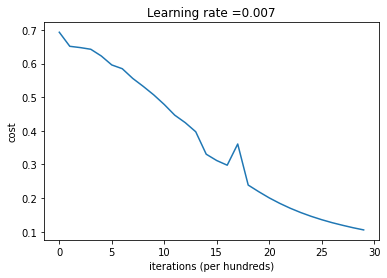

In [77]:
# l layer neural network
layers_dims = [12288, 20, 10, 7, 5, 1]

def L_layer_model(X, Y, layer_dims, learning_rate=0.007, num_iterations=3000, print_cost=True):
  np.random.seed(1)
  costs = []

  parameters = initialize_parameters_deep(layer_dims)
  for i in range(num_iterations):
    AL, caches = L_model_forward(X, parameters)
    cost = compute_cost(AL, Y)
    grads = L_model_backward(AL, Y, caches)
    parameters = update_parameters(parameters, grads, learning_rate)

    if print_cost and i % 100 == 0:
      print ("Cost after iteration %i: %f" %(i, cost))
      costs.append(cost)

  # plot the cost
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  return parameters

parameters = L_layer_model(train_x, train_y, layer_dims)

In [78]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.68


In [92]:
import imageio
from skimage.transform import resize
## START CODE HERE ##
my_label_y = [0] 
## END CODE HERE ##

image = np.array(imageio.imread("image.jpg"))
my_image = sresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

AttributeError: ignored